            deathIncrease
date                     
2020-01-13              0
2020-01-14              0
2020-01-15              0
2020-01-16              0
2020-01-17              0


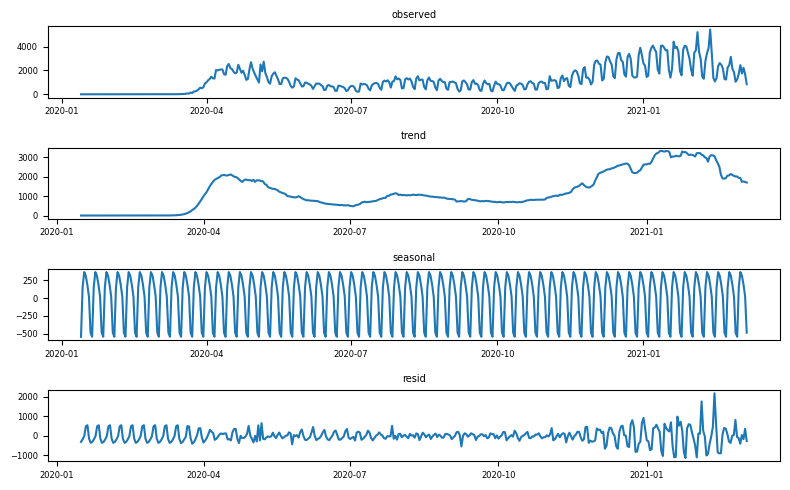

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as md
from statsmodels.graphics.tsaplots import plot_pacf as plot_acf

df = pd.read_csv('national-history.csv', sep=',', parse_dates=['date'], dayfirst=True, index_col='date',
                 date_format='%Y-%m-%d')[['deathIncrease']].asfreq('1 d').ffill()
print(df.head())
# df = df.head(200)
# df.deathIncrease = df.deathIncrease.diff(7).bfill()
decomp = seasonal_decompose(df.deathIncrease)
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 5))
for axis, title, series in zip(ax.reshape(-1), ['observed', 'trend', 'seasonal', 'resid'],
                        [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]):
    axis.set_title(title, fontsize=7)
    axis.plot(series)
    axis.xaxis.set_major_locator(md.MonthLocator(bymonth=(1, 4, 7, 10)))
    axis.tick_params(labelsize=6)
plt.tight_layout()

observed
	test statistic: -1.98644
	p_value: 0.29255 >= 0.05
diff 1
	test statistic: -4.21711
	p_value: 0.00062 < 0.05
diff 2
	test statistic: -4.40462
	p_value: 0.00029 < 0.05
boxcox
	test statistic: -3.82501
	p_value: 0.00266 < 0.05


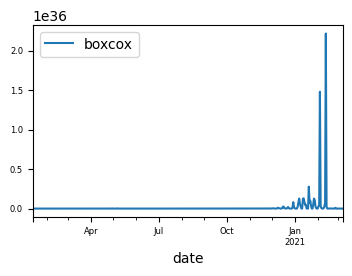

In [27]:
from statsmodels.tsa.stattools import adfuller

stat, p_value, *_ = adfuller(df.deathIncrease)
print_af = lambda t,s,p : print("{}\n\ttest statistic: {:.5f}\n\tp_value: {:.5f} "
                                .format(t, s, p)+('<' if p<0.05 else '>=')+' 0.05')
print_af('observed', stat, p_value)
# H0: временной ряд является нестационарным
# p_value > 0.05 => не можем опровергнуть нулевую гипотезу
for di in [1, 2]:
    col_name = 'diff{}'.format(di)
    df[col_name] = df.deathIncrease.diff(di).bfill() # yt=yt-y(t-1) 
    stat, p_value, *_ = adfuller(df[col_name])
    print_af('diff {}'.format(di), stat, p_value)
    
from scipy.special import boxcox
col_name = 'boxcox'
df[col_name] = boxcox(df.deathIncrease, 10)
stat, p_value, *_ = adfuller(df[col_name])
print_af(col_name, stat, p_value)
df.boxcox.plot(fontsize=6, figsize=(4, 2.5), legend=True)
plt.show()

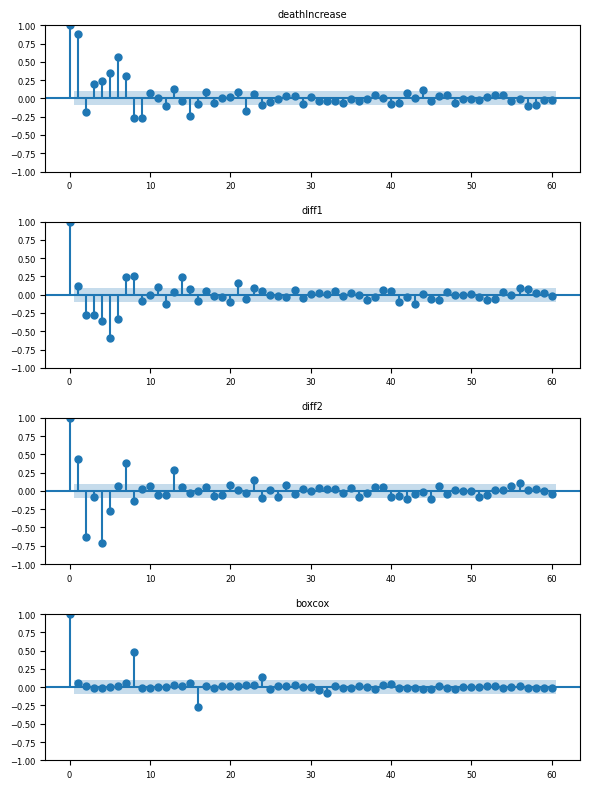

In [28]:
fig, ax = plt.subplots(nrows=len(df.columns), figsize=(6, 8))
for axis, column in zip(ax.reshape(-1), df.columns):
    plot_acf(x=df[column], ax=axis, lags=60)
    axis.set_title(column, fontsize=7)
    axis.tick_params(labelsize=6)
plt.tight_layout()

In [29]:
from pmdarima import auto_arima
train_data_size = int(len(df)*0.8)
predict_data_size = len(df)-train_data_size-1
model = auto_arima(df.deathIncrease[:train_data_size], start_p=0, start_q=0, test='adf', max_d=30, max_q=10,
           start_P=0, error_action ='ignore', supress_warnings=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4857.877, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4857.927, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4855.603, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4855.938, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4821.261, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4763.802, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4826.590, Time=0.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4758.100, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4815.876, Time=0.02 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4725.405, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4789.664, Time=0.03 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4627.241, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4637.438, Time=0.04 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4562.801, Time=0.33 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

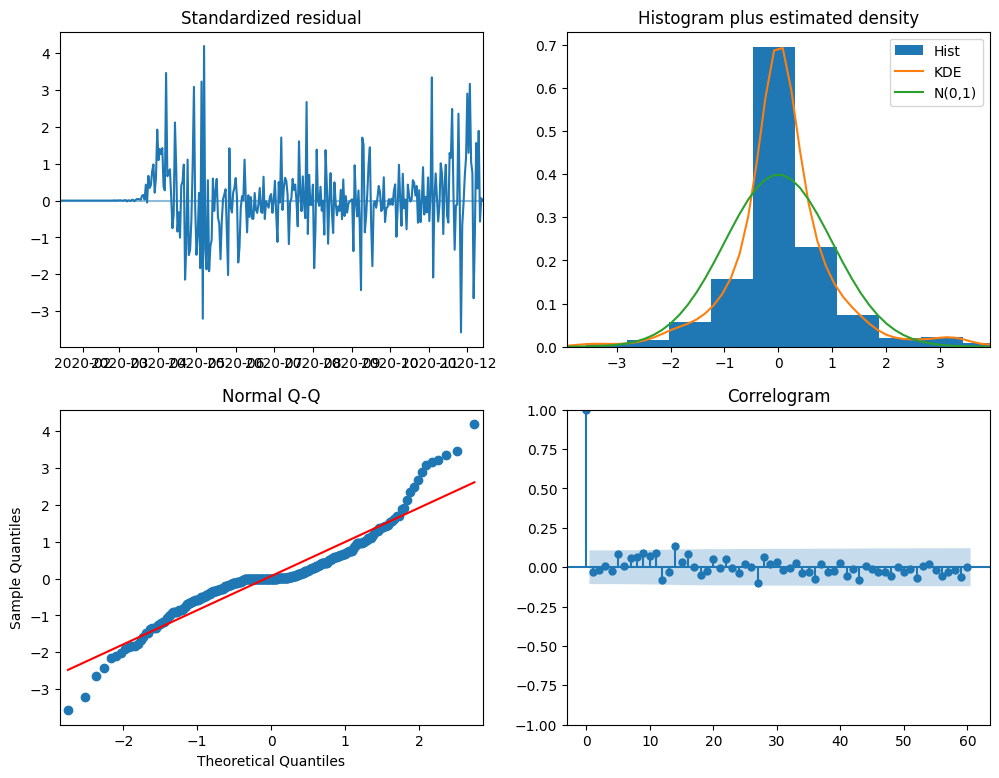

In [30]:
model.plot_diagnostics(figsize=(12,9), lags=60)
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_percentage_error

def draw(graph_title, predicted, conf_int=None):
    plt.plot(df.deathIncrease, label='observed')
    predicted.index = pd.date_range(df.index[-predict_data_size], periods=predict_data_size, freq='D')
    plt.plot(predicted, label='prediction')
    if conf_int is not None:
        plt.fill_between(predicted.index, conf_int[:, 0], conf_int[:, 1], alpha=.15)
    plt.title(graph_title, fontsize=8)
    plt.tick_params(labelsize=7)
    error = mean_absolute_percentage_error(df.deathIncrease.values[-predict_data_size:], predicted)
    plt.plot([], [], ' ', label='error={:.5f}'.format(error))
    plt.legend(fontsize=8, loc=3)
    plt.show()
    plt.close()

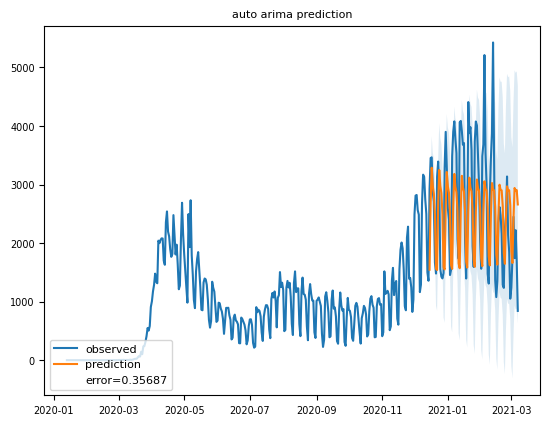

In [32]:
fitted, ci = model.predict(n_periods=predict_data_size, return_conf_int=True)
draw('auto arima prediction', fitted, ci)

In [33]:
from pmdarima.utils import diff_inv
import numpy as np
from sklearn.linear_model import LinearRegression

def _linear_regression_fit(data, shape, index, returnXtrain=False):
    Xtrain = data.iloc[:, index+1:].values.reshape(-1, shape)
    ytrain = data.iloc[:, index].values.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(Xtrain, ytrain)
    if returnXtrain:
        return lr.coef_.T, lr.intercept_[0], Xtrain
    return lr.coef_.T, lr.intercept_[0]

class ARIMA:
    def __init__(self, data, order):
        self.order = order
        self.input_data = data
        self.data = pd.DataFrame({'value': data.diff(self.order[1]).bfill()})
        self.phis, self.thetas, self.interceptAR, self.interceptMA = None, None, 0, 0
        
    def fit(self):
        self._fitAR(self.order[0])
        self._fitMA(self.order[2])
        return self
    
    def predict(self, n):
        temp_data = self.data.copy()
        for i in range(n):
            ar_terms = temp_data.value.values[-self.order[0]:]
            ma_terms = temp_data.residuals.values[-self.order[2]:]
            predictedAR = (np.dot(ar_terms, self.phis) - self.interceptAR)[0]
            predictedMA = (np.dot(ma_terms, self.thetas) - self.interceptMA)[0]
            predicted_value = predictedAR - predictedMA
            temp_data.loc[len(temp_data)] = pd.Series({'value': predicted_value,
                                                       'residuals': temp_data.iloc[-1].value - predicted_value})
        value = np.array(self.input_data[:self.order[1]].tolist()+temp_data.value[self.order[1]:].tolist())
        inv_diff_vals = diff_inv(value, self.order[1], 1)[-n:]
        return pd.Series(inv_diff_vals)

    def _fitAR(self, p):
        temp_data = self.data.copy()
        for i in range(1, p+1):
            temp_data['shift_value{}'.format(i)] = self.data.value.shift(i).bfill()
        self.phis, self.interceptAR, X_train = _linear_regression_fit(temp_data, p, 0, returnXtrain=True)
        predictedAR = X_train.dot(self.phis) + self.interceptAR
        self.data['residuals'] = self.data.value - predictedAR[:, 0]
        
    def _fitMA(self, q):
        temp_data = self.data.copy()
        for i in range(1, q+1):
            temp_data['shift{}'.format(i)] = temp_data.residuals.shift(i).bfill()
        self.thetas, self.interceptMA = _linear_regression_fit(temp_data, q, 1)


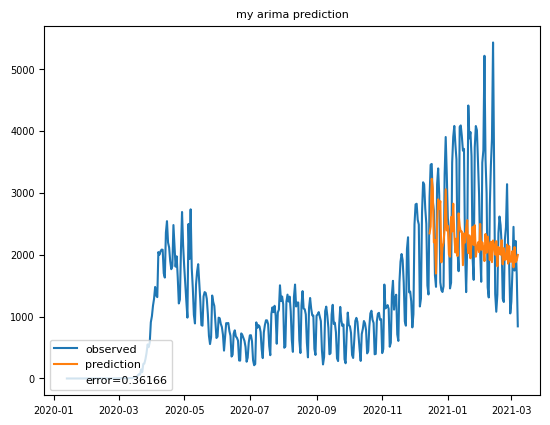

In [34]:
my_model = ARIMA(df.deathIncrease[:train_data_size], (5, 1, 4)).fit()
draw('my arima prediction', my_model.predict(predict_data_size))